In [152]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 100)
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import shapely.geometry as geom
# path / data
PATH_DATA = './data/'
AIRBNB_FILE = 'amsterdam_airbnb_listings.csv'

In [153]:
# load data
date_cols = ['last_scraped', 'host_since', 'first_review', 'calendar_last_scraped']
df= (pd.read_csv(PATH_DATA + AIRBNB_FILE, parse_dates=date_cols, decimal = ',')
    .dropna(how= 'all', axis=1))

df['price'] = df.price.str.replace('$', '')
df['price'] = df.price.str.replace(',', '')
df['price'] = df['price'].astype(float) 

df = df.rename(columns = {'longitude': 'lon', 'latitude': 'lat'})
# lon, lat to float
for col in ['lon', 'lat']:
    df[col] = df[col].astype(float)
    
df['geometry'] = df[['lon', 'lat']].apply(geom.Point, axis=1)
df = gp.GeoDataFrame(df)
df.crs={'init':'epsg:4269'} 
df = df.to_crs(epsg=3857)

# load the Amsterdam districts
neighbourhoods = gp.read_file('data/amsterdam_neighbourhoods.geojson').to_crs(epsg=3857)

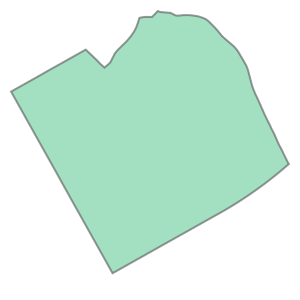

In [64]:
neighbourhoods.iloc[0][2]

Grab a basemap using contextily, a package to provide basemaps for data, best used for data in webmercator or raw WGS lon-lat coordinates.

Here we grab the basemap images for the total_bounds of our study area at a given zoom level, also specifying a different tile server from the default: the Stamen Maps toner-lite tiles for its aesthetics.

In [154]:
basemap, bounds = ctx.bounds2img(*df.total_bounds, zoom=11, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

In [155]:
# check how many tiles we need
ctx.howmany(*df.total_bounds, zoom=11)

Using zoom level 11, this will download 4 tiles


4

Text(0.5,1,'Emperical Distribution')

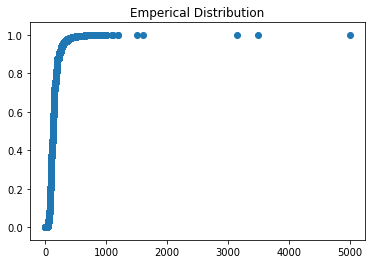

In [156]:
# let's viz the price
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

x, y = ecdf(df['price'])
plt.scatter(x,y)
plt.title('Emperical Distribution')

In [120]:
# Let's cut price above 1000
df = df[df.price <= 1000]

In [157]:
# create a normalized price column
from sklearn.preprocessing import MinMaxScaler
x = df['price'].values.reshape(-1, 1)
mms = MinMaxScaler()
x_scaled = mms.fit_transform(x)

prices_scaled = pd.DataFrame(x_scaled, columns=['price_scaled'])
df = pd.merge(df, prices_scaled, left_index=True, right_index=True)

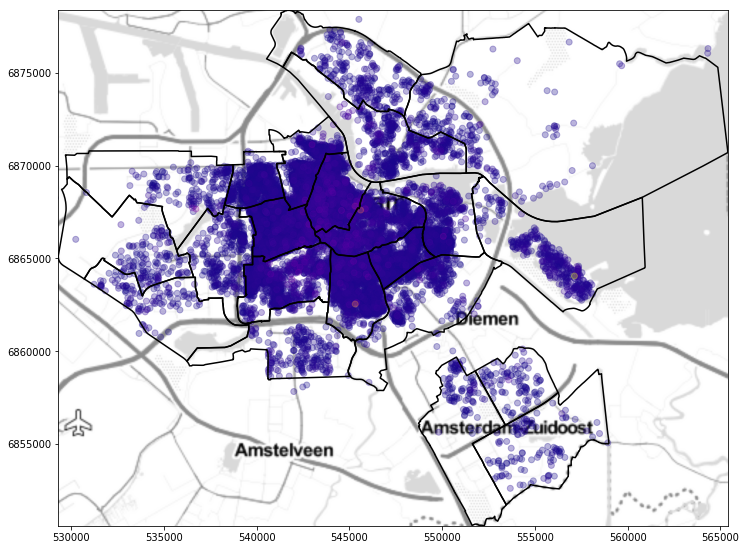

In [158]:
fig, ax = plt.subplots(figsize= [12,12])
neighbourhoods.boundary.plot(color='black', ax=ax)
#to keep the tiles aligned with your map's extent
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])
df.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.3)

In [159]:
district_price = df.groupby(['neighbourhood_cleansed']).price.median().to_frame()
district_price.sort_values(by='price', ascending=False)[:5]

,price
neighbourhood_cleansed,
Centrum-West,150.0
Centrum-Oost,149.0
IJburg - Zeeburgereiland,143.0
Zuid,129.0
De Pijp - Rivierenbuurt,125.0


In [160]:
neighbourhoods = neighbourhoods.merge(
                           district_price,
                           left_on='neighbourhood', 
                           right_index=True, how='left')
neighbourhoods = neighbourhoods.rename(columns=dict(price='median_price'))

The Quantiles scheme is one map classification method that GeoPanda includes, which are in turn based on PySAL

array([ 529306.03364502,  565409.72749655, 6850580.00959267,
       6878375.5091467 ])

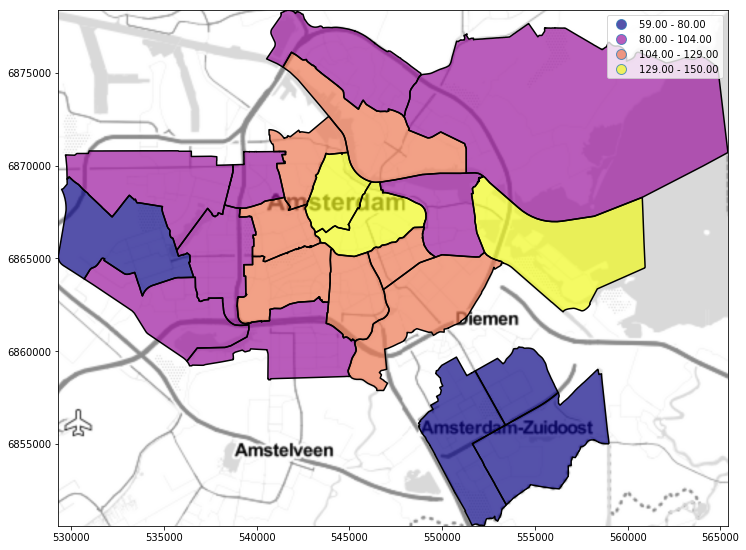

In [161]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
neighbourhoods.boundary.plot(color='black', ax=ax)
neighbourhoods.plot(column= 'median_price', scheme='Fisher_Jenks', k=4, legend=True,
                    cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(neighbourhoods.total_bounds[np.asarray([0,2,1,3])])

In [162]:
import mapclassify.api as mc

In [163]:
y = df['price']
ea5 = mc.Equal_Interval(y, k=10)

In [164]:
#Equal intervals splits the data range into  kk  equal-width bins:
ea5

                 Equal Interval                
 
 Lower              Upper                 Count
           x[i] <=  500.000               18420
 500.000 < x[i] <= 1000.000                 117
1000.000 < x[i] <= 1500.000                   6
1500.000 < x[i] <= 2000.000                   1
2000.000 < x[i] <= 2500.000                   0
2500.000 < x[i] <= 3000.000                   0
3000.000 < x[i] <= 3500.000                   2
3500.000 < x[i] <= 4000.000                   0
4000.000 < x[i] <= 4500.000                   0
4500.000 < x[i] <= 5000.000                   1

In [165]:
q5 = mc.Quantiles(y, k=5)
ei5 = mc.Equal_Interval(y, k=5)
mb5 = mc.Maximum_Breaks(y, k=5)
fj5 = mc.Fisher_Jenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

[361119.0, 961882.0, 965752.0, 430501.0]

Fisher Jenks is the optimal classifer.

In [166]:
bp = mc.Box_Plot(y)
bp

                   Box Plot                   
 
 Lower              Upper                Count
           x[i] <=  -22.500                  0
 -22.500 < x[i] <=   90.000               4656
  90.000 < x[i] <=  120.000               4747
 120.000 < x[i] <=  165.000               4593
 165.000 < x[i] <=  277.500               3520
 277.500 < x[i] <= 5000.000               1031

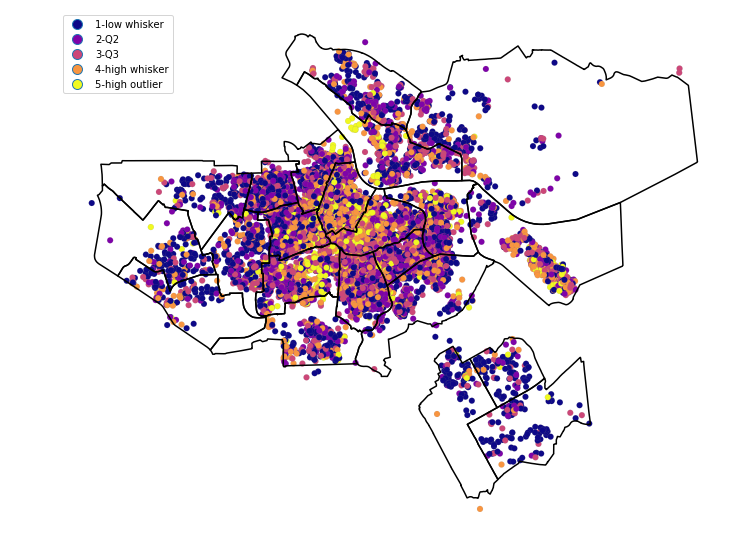

In [167]:
labels = ['0-low outlier', '1-low whisker',
          '2-Q2', '3-Q3', '4-high whisker', '5-high outlier']
bpl = [ labels[b] for b in bp.yb ]

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
neighbourhoods.boundary.plot(color='black', ax=ax)

(df.assign(cl=bpl).plot(column='cl', categorical=True, 
                        k=4, cmap='plasma', linewidth=0.1, ax=ax,
                        edgecolor='grey', legend=True))
ax.set_axis_off()